In [1]:
from pyspark.sql import SQLContext
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DateType
from datetime import date, timedelta
import datetime as dt
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.functions import col, avg, sum
import numpy as np
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import pandas as pd
import pyspark

In [2]:
log4jLogger = sc._jvm.org.apache.log4j
LOGGER = log4jLogger.LogManager.getLogger(__name__)
LOGGER.error("pyspark script logger initialized")

## Read Feature File

In [3]:
sc.stop()
sc = pyspark.SparkContext(master="spark://172.16.27.208:7077",appName="spark")
sc

<SparkContext master=spark://172.16.27.208:7077 appName=spark>

In [4]:
print(sc.getConf().get("spark.default.parallelism"))

24


In [7]:
base_path = "/home/test5/Desktop/smart-meters-in-london/Feature_File/"
sqlcontext = SQLContext(sc)

In [8]:
df = []
for mth in range(1,13):
    month_df = sqlcontext.read.csv(base_path+"Cleaned_2013_Features_mth_{}.csv".format(mth),header = True,inferSchema=True,)
    if mth == 1:
        df = sqlcontext.createDataFrame(df,month_df.schema)
    df = df.union(month_df)

In [9]:
df = df.repartition(480,"LCLid")

In [11]:
df = df.drop("_c0","diff_energy_week_t_1","count","date2")
df.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: d

## Disaggregated Approach using RF

## Perform :
    * 1 hot encoding
    * Vector Assembler

In [12]:
outputCols = ["weekDay_index","precipType_index","summary_index","stdorToU_index","Acorn_grouped_index"]
df_encoded = df
for col in outputCols: 
    encoder = OneHotEncoder(inputCol=col, outputCol="category_{}".format(col))
    df_encoded = encoder.transform(df_encoded).cache()
df_encoded.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: d

In [52]:
inputCols = ["weekDay","precipType","summary","stdorToU","Acorn_grouped","count"]
columns = df_encoded.columns
feature_col = columns[4:]
feature_col.append(columns[2])
feature_col = set(feature_col) - set(inputCols)
feature_col = feature_col - set(outputCols)
feature_col = list(feature_col)
len(feature_col)

63

In [16]:
# Dropping row with Na
df_encoded = df_encoded.na.drop()

In [17]:
vecAssembler = VectorAssembler(inputCols=feature_col, outputCol="features")
df_feature = vecAssembler.transform(df_encoded)
df_feature.take(1)

[Row(LCLid='MAC004503', date=datetime.datetime(2013, 1, 1, 0, 0), hour=0, energy(kWh/h)=0.222, month=1, weekDay='Tue', 1_diff_energy_t_0=0.076, 2_diff_energy_t_0=0.254, 3_diff_energy_t_0=0.077, 4_diff_energy_t_0=0.173, 5_diff_energy_t_0=0.075, 6_diff_energy_t_0=0.234, 7_diff_energy_t_0=0.097, 1_diff_energy_t_1=0.269, 2_diff_energy_t_1=0.248, 3_diff_energy_t_1=0.21, 4_diff_energy_t_1=0.253, 5_diff_energy_t_1=0.115, 6_diff_energy_t_1=0.273, 7_diff_energy_t_1=0.208, 1_diff_energy_t_2=0.262, 2_diff_energy_t_2=0.747, 3_diff_energy_t_2=0.294, 4_diff_energy_t_2=0.297, 5_diff_energy_t_2=0.264, 6_diff_energy_t_2=0.27, 7_diff_energy_t_2=0.272, diff_energy_week_t_2=0.073, diff_energy_week_t_3=0.072, diff_energy_week_t_4=0.071, mean_1=0.1904583333333333, mean_2=0.18050000000000002, mean_3=0.21045833333333333, mean_4=0.24116666666666667, mean_5=0.20808333333333331, mean_6=0.18316666666666667, mean_7=0.20299999999999999, min_1=0.074, max_1=0.828, min_2=0.074, max_2=0.53, min_3=0.075, max_3=0.861, mi

In [18]:
df_feature = df_feature.withColumnRenamed("energy(kWh/h)","label")
df_feature = df_feature.withColumn("date",df_feature["date"].cast(DateType()))
df_feature.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullab

##  actual and Predicted for given day

In [19]:
def get_aggregate(df):
    list = ["date","hour"]
    df = df.groupBy(list).agg(sum("label"),sum("prediction"))    
    return df

def select_predicted_actual(df,date,LCLid=None):
    list = []
    if LCLid != None:
        list = df.where((df["LCLid"] == LCLid) & (df["date"] == date)).select("label","prediction").collect()
    else:
        list = df.where((df["date"] == date)).select("label","prediction").collect()
    actual = [int(row['label']) for row in list]
    predicted = [int(row['prediction']) for row in list]
    return actual,predicted

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean(np.abs((y_true - y_pred)**2)))

## Train-Test Split

In [55]:
train_df = df_feature.where(df_feature["date"] <= date(2013,10,31))
test_df = df_feature.where(df_feature["date"] > date(2013,10,31))# & (df_feature["date"] <= date(2013,1,2)))
#plits = train_df.randomSplit([0.01, 0.01,0.98], 24)
#splits[0].count()

print("Train_point = {}, Test_point = {}".format(train_df.count(),test_df.count()))

## RandomForest

In [21]:
# rf = RandomForestRegressor(seed=123)
# paramGrid = ParamGridBuilder()\
#     .addGrid(rf.numTrees,[10,20,50]) \
#     .addGrid(rf.maxDepth,[10,15,20])\
#     .addGrid(rf.maxBins,[64,128])\
#     .addGrid(rf.featureSubsetStrategy,["auto","sqrt"])\
#     .build()
# tvs = TrainValidationSplit(estimator=rf,
#                            estimatorParamMaps=paramGrid,
#                            evaluator=RegressionEvaluator(),
#                            # 80% of the data will be used for training, 20% for validation.
#                            trainRatio=0.8)
# model = tvs.fit(train_df)

## Execute this 
rf = RandomForestRegressor(numTrees=20,maxDepth=10,maxBins=128,seed=4)
model = rf.fit(train_df)
best_model = model

In [25]:
model.save(base_path+"../Model/rf_model_disagg")

In [54]:
model.numFeatures
# best_model = model.bestModel
# print(" RF optimal num_trees = {}".format(best_model.getNumTrees))

79

In [ ]:
{param[0].name: param[1] for param in best_model.extractParamMap().items()}

In [26]:
pred_val = best_model.transform(test_df)
pred_val.printSchema()
# evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName="rmse")
# accuracy = evaluator.evaluate(pred_val)

root
 |-- LCLid: string (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullab

In [ ]:
# print(accuracy)

## Gradient Boosted Tree

In [56]:
# gbt = GBTRegressor(seed=123)
# paramGrid = ParamGridBuilder()\
#     .addGrid(gbt.maxIter,[10,20,50]) \
#     .addGrid(gbt.maxDepth,[10,15,20])\
#     .addGrid(gbt.maxBins,[64,128])\
#     .build()
# tvs = TrainValidationSplit(estimator=gbt,
#                            estimatorParamMaps=paramGrid,
#                            evaluator=RegressionEvaluator(),
#                            # 80% of the data will be used for training, 20% for validation.
#                            trainRatio=0.8)
# gbt_model = tvs.fit(splits[0])

## Execute this 
gbt = GBTRegressor(maxBins=128,maxDepth=10)
gbt_model = gbt.fit(train_df)
best_model = gbt_model


In [57]:
gbt_model.save(base_path+"../Model/gbt_model_disagg")

In [37]:
{param[0].name: param[1] for param in gbt_model.bestModel.extractParamMap().items()}
best_model = gbt_model.bestModel

{'cacheNodeIds': False,
 'checkpointInterval': 10,
 'featuresCol': 'features',
 'impurity': 'variance',
 'labelCol': 'label',
 'lossType': 'squared',
 'maxBins': 128,
 'maxDepth': 10,
 'maxIter': 10,
 'maxMemoryInMB': 256,
 'minInfoGain': 0.0,
 'minInstancesPerNode': 1,
 'predictionCol': 'prediction',
 'seed': 123,
 'stepSize': 0.1,
 'subsamplingRate': 1.0}

In [58]:
pred_val = best_model.transform(test_df)
pred_val.printSchema()
# evaluator = RegressionEvaluator(labelCol='label', predictionCol='prediction', metricName="rmse")
# accuracy = evaluator.evaluate(pred_val)

root
 |-- LCLid: string (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullab

In [42]:
print(accuracy)

0.38920046777462886


In [ ]:
## COmmon Method now on

In [59]:
pred_val.select("LCLid","label","prediction").show()

+---------+-----+-------------------+
|    LCLid|label|         prediction|
+---------+-----+-------------------+
|MAC004503|0.101|0.12002645184585364|
|MAC004503|0.074|0.11593906777478033|
|MAC004503|0.074| 0.0713337521467141|
|MAC004503|0.076| 0.0713337521467141|
|MAC004503|0.073| 0.0713337521467141|
|MAC004503|0.074| 0.0713337521467141|
|MAC004503|0.074| 0.1129592416810492|
|MAC004503| 0.08|0.12452288074911157|
|MAC004503|0.255|0.20800297550147756|
|MAC004503|  0.1|0.14507132988783608|
|MAC004503|0.074| 0.1463090329595952|
|MAC004503|0.074|0.15488072174927547|
|MAC004503| 0.96|0.34788340791239686|
|MAC004503|0.074| 0.5709833598388937|
|MAC004503|0.076|0.17549155916543344|
|MAC004503|0.073| 0.1243045490898714|
|MAC004503|0.225|0.18895826036415675|
|MAC004503|0.711| 0.3601609346158464|
|MAC004503|0.191| 0.3368149079534086|
|MAC004503|0.237|0.22098255849088633|
+---------+-----+-------------------+
only showing top 20 rows



In [60]:
aggregate_df = get_aggregate(pred_val)
aggregate_df = aggregate_df.withColumnRenamed("sum(label)","label")
aggregate_df = aggregate_df.withColumnRenamed("sum(prediction)","prediction")

In [61]:
aggregate_df.select("label","prediction").show()

+------------------+------------------+
|             label|        prediction|
+------------------+------------------+
|           1850.66| 1830.736373575817|
| 860.1129999999998| 902.7747794271276|
|1854.3080000000004|1765.1863988597788|
|1559.6259999999997|  1710.51866782889|
|          1625.787|1662.7765272723411|
|1916.0330000000026|1967.9777272913066|
| 2137.370000000001|1902.0775502371955|
|          1594.767|1516.2670752008305|
| 928.5659999999992|  937.028065957616|
| 2711.079000000002|2581.2813063709314|
|1761.7750000000008|1936.3699100787185|
|1525.3720000000003|1719.4133168781752|
|2066.3269999999984| 2127.834528339547|
|1970.6580000000008|1965.8012723599907|
|2346.3759999999984|2046.2410583736996|
| 930.2539999999996| 972.4952717482308|
|1314.1670000000008|1290.5563554476994|
| 1690.225000000001|1704.7974787834876|
|1692.1940000000006| 1850.925715146716|
|2141.3299999999995|2292.1028830339988|
+------------------+------------------+
only showing top 20 rows



## Own Metric

In [62]:
train_start_date = date(2013,11,1)
train_end_date = date(2013,12,31)
y_date = []
Mape_date = []
rmse_date = []
while train_start_date <= train_end_date:
    print(train_start_date)
    y_actual,y_pred = select_predicted_actual(aggregate_df,train_start_date)
    if len(y_actual) == 0:
        train_start_date = train_start_date + timedelta(1)
        continue
    Mape_date.append(mean_absolute_percentage_error(y_actual,y_pred))
    rmse_date.append(root_mean_squared_error(y_actual,y_pred))
    y_date.append(train_start_date)
    train_start_date = train_start_date + timedelta(1)

2013-11-01
2013-11-02
2013-11-03
2013-11-04
2013-11-05
2013-11-06
2013-11-07
2013-11-08
2013-11-09
2013-11-10
2013-11-11
2013-11-12
2013-11-13
2013-11-14
2013-11-15
2013-11-16
2013-11-17
2013-11-18
2013-11-19
2013-11-20
2013-11-21
2013-11-22
2013-11-23
2013-11-24
2013-11-25
2013-11-26
2013-11-27
2013-11-28
2013-11-29
2013-11-30
2013-12-01
2013-12-02
2013-12-03
2013-12-04
2013-12-05
2013-12-06
2013-12-07
2013-12-08
2013-12-09
2013-12-10
2013-12-11
2013-12-12
2013-12-13
2013-12-14
2013-12-15
2013-12-16
2013-12-17
2013-12-18
2013-12-19
2013-12-20
2013-12-21
2013-12-22
2013-12-23
2013-12-24
2013-12-25
2013-12-26
2013-12-27
2013-12-28
2013-12-29
2013-12-30
2013-12-31


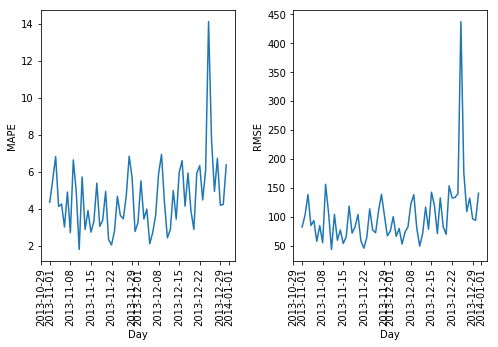

In [63]:
#del y_date[2]
# fig, (ax1,ax2) = plt.subplots(1,2, figsize =(8,6))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# ax1.xaxis.set_major_locator(mdates.DayLocator())
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
# ax2.xaxis.set_major_locator(mdates.DayLocator())
# ax1.plot(y_date,Mape_date)
# ax2.plot(y_date,rmse_date)
# fig.autofmt_xdate()
# ax1.set_xlabel('k')
# ax1.set_ylabel('cost')
date_time = pd.to_datetime(y_date)
DF = pd.DataFrame()
DF['Mape_date'] = Mape_date
DF = DF.set_index(date_time)

DF1 = pd.DataFrame()
DF1['rmse_date'] = rmse_date
DF1 = DF1.set_index(date_time)
fig, (ax1,ax2) = plt.subplots(1,2, figsize =(8,6))
fig.subplots_adjust(bottom=0.3,wspace = 0.3)
error = ["MAPE","RMSE"]
cnt = 0
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)
    plt.xlabel("Day")
    plt.ylabel(error[cnt])
    cnt += 1
ax1.plot(DF)
ax2.plot(DF1)

In [64]:
from statistics import mean
print("Mean RMSE = {}, Mean Mape = {}".format(mean(rmse_date),mean(Mape_date)))

Mean RMSE = 100.7070569349709, Mean Mape = 4.584451716978254


In [65]:
fig.savefig(base_path+"../plot/gbt_model_disagg")